In [1]:
# LSTM and HW implementations refer to:
# https://github.com/thowan/predictive-autoscaler/blob/master/kube/online/offline-2methods.py
# Author of LSTM and HW implementations: Thomas Wang(thowan)

import pymongo
import math
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.filterwarnings('ignore')

In [2]:
mongoclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = mongoclient['ema-5-3-aload']
db.name

'ema-5-3-aload'

In [3]:
collist = db.list_collection_names()
collist

['vpa', 'usage', 'requests']

In [4]:
# convert cpu unit 'n' to 'm'
def convert_cpu(x):
    if x != 0:
        if x[-1] == 'n':
            return round(int(x[:-1])/1000000)
        elif x[-1] == 'm':
            return int(x[:-1])
    else:
        return 0
    
# convert memory unit 'k' and 'Ki' to 'Mi'
# 1k = 1000/1024 Ki = 1000/1024**2 Mi
def convert_mem(x):
    if x != 0:
        if x[-1] == 'k':
            return round(int(x[:-1])*1000/1024**2)
        elif x[-2:] == 'Ki':
            return round(int(x[:-2])/1024)
        elif x[-2:] == 'Mi':
            return int(x[:-2])
    else:
        return 0

In [5]:
record = {}
collist = ['usage', 'requests']
for col in collist:
    record[col] = pd.DataFrame(list(db[col].find()))
    # convert timestamp to time
    record[col]['time'] = pd.to_datetime(record[col]['time'],unit='s').round('1s')
    record[col]['cpu'] = record[col]['cpu'].apply(lambda x: convert_cpu(x))
    record[col]['cpu'] = record[col]['cpu'].fillna(0)
    record[col]['memory'] = record[col]['memory'].apply(lambda x: convert_mem(x))

In [6]:
request = record['requests']
usage = record['usage']
request = request[request['pod_name'] == 'redis-master-0']
usage = usage[usage['pod_name'] == 'redis-master-0']
# usage.head()

In [7]:
series = np.array(usage.cpu)

In [8]:
vpa = pd.DataFrame(list(db['vpa'].find()))
vpa['time'] = pd.to_datetime(vpa['time'],unit='s').round('1s')
vpa['target_cpu'] = vpa['target_cpu'].apply(lambda x: convert_cpu(x))
vpa['target_mem'] = vpa['target_mem'].apply(lambda x: convert_mem(x))
vpa['lowerBound_cpu'] = vpa['lowerBound_cpu'].apply(lambda x: convert_cpu(x))
vpa['lowerBound_mem'] = vpa['lowerBound_mem'].apply(lambda x: convert_mem(x))
vpa['upperBound_cpu'] = vpa['upperBound_cpu'].apply(lambda x: convert_cpu(x))
vpa['upperBound_mem'] = vpa['upperBound_mem'].apply(lambda x: convert_mem(x))
# vpa.head()

In [9]:
def split_sequence(sequence, n_steps_in, n_steps_out, ywindow):
    X, y = list(), list()

    for i in range(len(sequence)-ywindow-n_steps_in+1):
        # find the end of this pattern
        end_ix = i + n_steps_in

        # gather input and output parts of the pattern
        # print(sequence[end_ix:end_ix+ywindow])
        seq_x, seq_y = sequence[i:end_ix], [np.percentile(sequence[end_ix:end_ix+ywindow], 90), np.percentile(sequence[end_ix:end_ix+ywindow], 60), np.percentile(sequence[end_ix:end_ix+ywindow], 98)]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [10]:
def trans_foward(arr):
    global scaler
    out_arr = scaler.transform(arr.reshape(-1, 1))
    return out_arr.flatten()

def trans_back(arr):
    global scaler
    out_arr = scaler.inverse_transform(arr.flatten().reshape(-1, 1))
    return out_arr.flatten()

In [11]:
def create_lstm(n_steps_in, n_steps_out, n_features,raw_seq, ywindow):
    global scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(raw_seq.reshape(-1, 1))
    #print("First 10 of raw_seq:", raw_seq[:20])
    dataset = trans_foward(raw_seq)
    # split into samples
    X, y = split_sequence(dataset, n_steps_in, n_steps_out, ywindow)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # define model
    model = Sequential()
    
    # Multi-layer model 
    model.add(LSTM(50, return_sequences=True , input_shape=(n_steps_in, n_features)))
    # model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))

    # Single layer model
    # model.add(LSTM(100, input_shape=(n_steps_in, n_features)))

    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, y, epochs=10, verbose=0)
    
    return model

In [12]:
def lstm_predict(input_data,model,n_steps_in,n_features): 
    x_input = np.array(trans_foward(input_data))
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    return trans_back(yhat)

In [13]:
def calc_n(i, season_len, history_len):
    season = math.ceil((i+1)/season_len)
    history_start_season = season - (history_len/season_len)
    if history_start_season < 1:
        history_start_season = 1
    history_start = (history_start_season-1) * season_len 
    n = int(i - history_start)
    return n

In [14]:
HW_target, HW_upper, HW_lower = 90, 98, 60
lstm_target, lstm_upper, lstm_lower = 90, 98, 60

season_len = 60
history_len = season_len * 3
scaling_start_index = season_len * 2

window_past = 1
window_future = 24

i = scaling_start_index
rescale_buffer = 120
rescale_cooldown = 18
lstm_cooldown = 0
hw_cooldown = 0

model = None
hw_model = None
steps_in, steps_out, n_features, ywindow = 48, 3, 1, 24

lstm_CPU_request = 250
hw_CPU_request =250

lstm_requests = [lstm_CPU_request] * scaling_start_index
lstm_targets = []
lstm_uppers = []
lstm_lowers = []

hw_requests = [hw_CPU_request] * scaling_start_index
hw_targets = []
hw_uppers = []
hw_lowers = []

while i <= len(series):
    series_part = series[:i]
    n = calc_n(i, season_len, history_len)
    
    #HW model
    if i % 60 == 0 or hw_model is None:
        hw_model = ExponentialSmoothing(series_part[-n:], trend="add", seasonal="add", seasonal_periods=season_len)
        model_fit = hw_model.fit()
        
    hw_window = model_fit.predict(start=n-window_past,end=n+window_future)
    hw_target = np.percentile(hw_window, HW_target)
    hw_lower = np.percentile(hw_window, HW_lower)
    hw_upper = np.percentile(hw_window, HW_upper)
    if hw_target < 0:
        hw_target = 0
    if hw_lower < 0:
        hw_lower = 0
    if hw_upper < 0:
        hw_upper = 0
    hw_targets.append(hw_target)
    hw_uppers.append(hw_upper)
    hw_lowers.append(hw_lower)
    
    #LSTM model
    if i % 60 == 0 or model is None:
        model = create_lstm(steps_in, steps_out, n_features, series_part, ywindow)
    
    input_data = np.array(series_part[-steps_in:])
    output_data = lstm_predict(input_data, model, steps_in, n_features)
    
    lstm_target = output_data[0]
    lstm_lower = output_data[1]
    lstm_upper = output_data[2]
    if lstm_target < 0:
        lstm_target = 0
    if lstm_lower < 0:
        lstm_lower = 0
    if lstm_upper < 0:
        lstm_upper = 0
    lstm_targets.append(lstm_target)
    lstm_uppers.append(lstm_upper)
    lstm_lowers.append(lstm_lower)
    
    # HW scaling 
    hw_CPU_request_unbuffered = hw_CPU_request - rescale_buffer
    # If no cool-down
    if (hw_cooldown == 0):
        # If request change greater than 50
        if (abs(hw_CPU_request - (hw_target + rescale_buffer)) > 50):
            # If above upper
            if hw_CPU_request_unbuffered > hw_upper:
                hw_CPU_request = hw_target + rescale_buffer
                hw_cooldown = rescale_cooldown
            # elseIf under lower
            elif hw_CPU_request_unbuffered < hw_lower: 
                hw_CPU_request = hw_target + rescale_buffer
                hw_cooldown = rescale_cooldown

    # Reduce cooldown 
    if hw_cooldown > 0:
        hw_cooldown -= 1

    hw_requests.append(hw_CPU_request)

    # LSTM scaling
    lstm_CPU_request_unbuffered = lstm_CPU_request - rescale_buffer
        
    # If no cool-down
    if (lstm_cooldown == 0):
        # If request change greater than 50
        if (abs(lstm_CPU_request - (lstm_target + rescale_buffer)) > 50):
            # If above upper
            if lstm_CPU_request_unbuffered > lstm_upper:
                lstm_CPU_request = lstm_target + rescale_buffer
                lstm_cooldown = rescale_cooldown
            # elseIf under lower
            elif lstm_CPU_request_unbuffered < lstm_lower: 
                lstm_CPU_request = lstm_target + rescale_buffer
                lstm_cooldown = rescale_cooldown

    # Reduce cooldown 
    if lstm_cooldown > 0:
        lstm_cooldown -= 1

    lstm_requests.append(lstm_CPU_request)
    
    
    i += 1

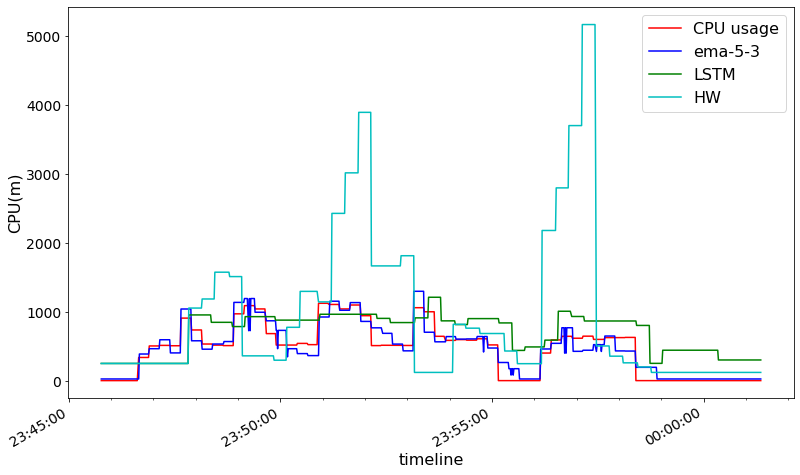

In [19]:
fig, ax = plt.subplots(1,1,figsize=(13,8),sharex=True,sharey=True)
# ax.scatter(request.time, request.cpu,marker='.',label='request')
ax.plot(usage.time, usage.cpu,label='CPU usage',color='r')
ax.plot(vpa.time, vpa.target_cpu,label='ema-5-3',color='b')
ax.plot(usage.time, lstm_requests[:len(usage.time)],label='LSTM',color='g')
ax.plot(usage.time, hw_requests[:len(usage.time)],label='HW',color='c')
ax.legend(fontsize=16)
ax.set_ylabel('CPU(m)', fontsize=16)
ax.set_xlabel('timeline', fontsize=16)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_minor_locator(mdates.MinuteLocator())
fig.autofmt_xdate() #rotate labels
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.show()

In [16]:
def evaluate(usage, prediction):
    slack = list(map(operator.sub, prediction, usage))
    slack_total = 0
    insufficient_count = 0
    insufficient_total = 0
    for i in slack:
        if i < 0:
            insufficient_count += 1
            insufficient_total += abs(i)
        else:
            slack_total += i
    return slack_total/len(usage), insufficient_count/len(usage)*100, insufficient_total/len(usage)

In [18]:
ema = []
lstm = []
hw = []
ema = evaluate(usage.cpu, vpa.target_cpu)
lstm = evaluate(usage.cpu, lstm_requests)
hw = evaluate(usage.cpu, hw_requests)
print("\tAvg. slack(m)\t Insufficient CPU(%)\t Avg. insufficient CPU(m)")
print("ema-5-3:", ema[0], ema[1], ema[2])
print("lstm:", lstm[0], lstm[1], lstm[2])
print("hw:", hw[0], hw[1], hw[2])

	Avg. slack(m)	 Insufficient CPU(%)	 Avg. insufficient CPU(m)
ema-5-3: 51.864444444444445 34.44444444444444 42.52777777777778
lstm: 269.3285110473633 22.11111111111111 40.66776285807292
hw: 588.5409571426085 26.333333333333332 111.40349400092363
